## 8. PCA и понижение размерности

**Проклятие размерности (Curse of Dimensionality)** — феномен, когда с ростом числа признаков (размерности) данные становятся всё более "разреженными" в пространстве признаков. Последствия: алгоритмы работают медленнее, требуют экспоненциально больше данных, расстояния между точками становятся менее информативными.

**Понижение размерности (Dimensionality Reduction)** — преобразование данных из высокоразмерного пространства в низкоразмерное с минимальной потерей информации. Цели: визуализация, ускорение алгоритмов, борьба с переобучением, удаление шума.

**PCA (Principal Component Analysis, Анализ главных компонент)** — метод линейного понижения размерности. Находит новые оси координат (главные компоненты), вдоль которых данные имеют максимальную дисперсию. Первая компонента объясняет максимум дисперсии, вторая — максимум из оставшейся (ортогональна первой), и т.д.

**Главная компонента (Principal Component, PC)** — новая ось координат в пространстве признаков, направленная вдоль максимальной дисперсии данных. Математически: собственный вектор ковариационной матрицы.

**Матрица ковариации (Covariance Matrix)** — квадратная матрица, элемент (i, j) которой = ковариация между признаками i и j. Показывает, как признаки коррелируют друг с другом. Формула: `Cov(X) = (1/n) × X^T × X` 

**Собственные векторы и собственные значения (Eigenvectors & Eigenvalues)** — для матрицы A собственный вектор v и собственное значение λ удовлетворяют: `A × v = λ × v`. В PCA собственные векторы ковариационной матрицы = главные компоненты, собственные значения = дисперсия вдоль этих компонент.

**Explained Variance Ratio** — доля дисперсии, объяснённая каждой главной компонентой. Формула: `explained_variance_ratio[i] = eigenvalue[i] / Σ(eigenvalues)`. Сумма по всем компонентам = 1.0 (100%).

**Cumulative Explained Variance** — накопленная объяснённая дисперсия. Показывает, сколько процентов информации сохраняется при использовании первых k компонент.

**Reconstruction (Реконструкция)** — восстановление исходных данных из сжатых (главных компонент). Формула: `X_reconstructed = X_pca × components^T + mean`. Чем больше компонент используем, тем точнее реконструкция.

**Whitening (Отбеливание)** — преобразование данных так, чтобы главные компоненты имели единичную дисперсию и были некоррелированы (ковариационная матрица = единичная).

**Линейность PCA** — PCA находит только **линейные комбинации** признаков. Для нелинейных зависимостей используются: Kernel PCA, t-SNE, UMAP, Autoencoders.

**Важно:** PCA требует **масштабированных** данных (StandardScaler), иначе признаки с большим масштабом доминируют

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import time

sns.set_theme(style="whitegrid", font_scale=1.1)

# Загрузка MNIST (используем sklearn встроенный или Kaggle CSV)
from sklearn.datasets import fetch_openml

print("Загрузка MNIST (может занять 1-2 минуты)...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'], mnist['target'].astype(int)

print(f"MNIST датасет:")
print(f"  X: {X.shape} (70,000 изображений × 784 пикселей)")
print(f"  y: {y.shape} (метки цифр 0-9)")
print(f"  Диапазон пикселей: [{X.min():.0f}, {X.max():.0f}]")

Загрузка MNIST (может занять 1-2 минуты)...
MNIST датасет:
  X: (70000, 784) (70,000 изображений × 784 пикселей)
  y: (70000,) (метки цифр 0-9)
  Диапазон пикселей: [0, 255]


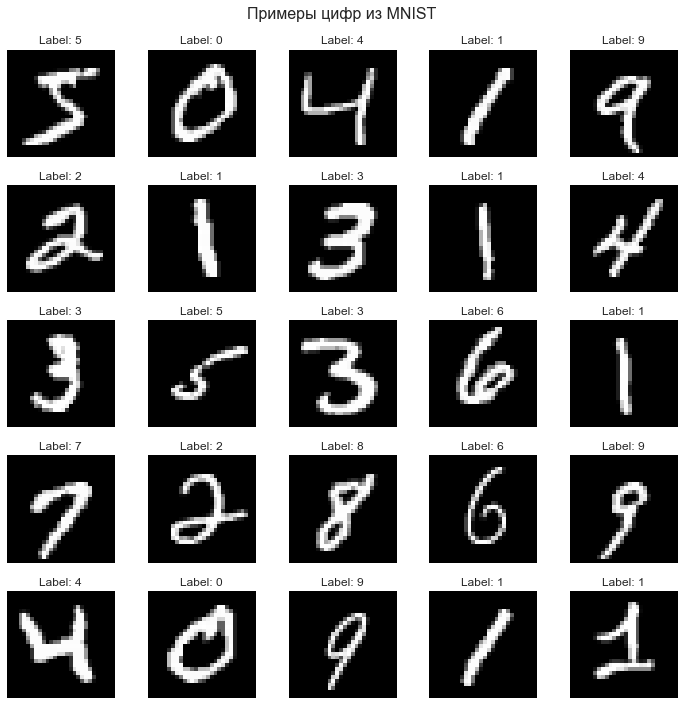


💡 Каждое изображение:
  • 28×28 пикселей = 784 признака
  • Значение пикселя: 0 (белый) до 255 (чёрный)
  • Метка: цифра 0-9


In [3]:
# Визуализация первых 25 цифр
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    # Reshape 784 → 28×28
    image = X[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Label: {y[i]}', fontsize=12)
    ax.axis('off')

plt.suptitle('Примеры цифр из MNIST', fontsize=16)
plt.tight_layout()
plt.show()

print("\n💡 Каждое изображение:")
print("  • 28×28 пикселей = 784 признака")
print("  • Значение пикселя: 0 (белый) до 255 (чёрный)")
print("  • Метка: цифра 0-9")

Распределение цифр:
 Цифра  Количество
     0        6903
     1        7877
     2        6990
     3        7141
     4        6824
     5        6313
     6        6876
     7        7293
     8        6825
     9        6958


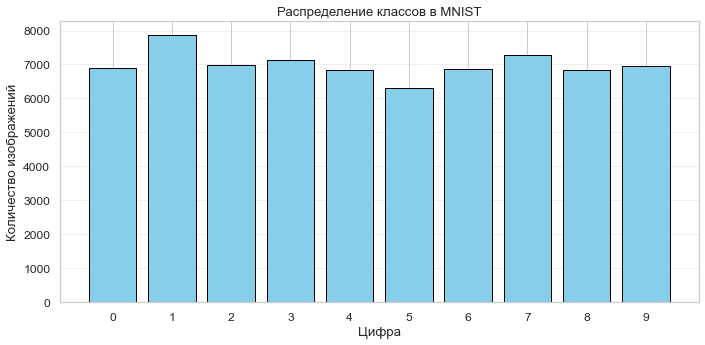


✅ Датасет сбалансирован (~7000 примеров каждой цифры)


In [4]:
# Распределение классов
unique, counts = np.unique(y, return_counts=True)
class_dist = pd.DataFrame({'Цифра': unique, 'Количество': counts})
print("Распределение цифр:")
print(class_dist.to_string(index=False))

# Визуализация
plt.figure(figsize=(10, 5))
plt.bar(unique, counts, color='skyblue', edgecolor='black')
plt.xlabel('Цифра')
plt.ylabel('Количество изображений')
plt.title('Распределение классов в MNIST')
plt.xticks(unique)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\n✅ Датасет сбалансирован (~7000 примеров каждой цифры)")

In [5]:
# TODO: используем подвыборку для ускорения (10,000 примеров)
# Для занятия достаточно; полный MNIST (70k) можно использовать дома
n_samples = 10000
X_subset = X[:n_samples]
y_subset = y[:n_samples]

print(f"Используем {n_samples} примеров для занятия")
print(f"  X_subset: {X_subset.shape}")
print(f"  y_subset: {y_subset.shape}")

# ВАЖНО: масштабируем признаки (пиксели 0-255 → mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_subset)

print("Масштабирование выполнено (StandardScaler)")
print("   Это КРИТИЧНО для PCA — иначе пиксели с большими значениями доминируют")

Используем 10000 примеров для занятия
  X_subset: (10000, 784)
  y_subset: (10000,)
Масштабирование выполнено (StandardScaler)
   Это КРИТИЧНО для PCA — иначе пиксели с большими значениями доминируют


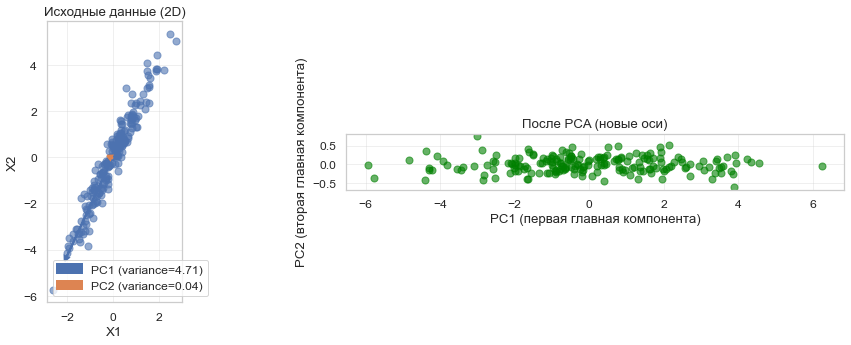

Что сделал PCA:
1. Нашёл направление максимальной дисперсии (PC1, красная стрелка)
2. Нашёл ортогональное направление с максимальной остаточной дисперсией (PC2)
3. Спроецировал данные на эти новые оси

Explained variance:
  PC1: 99.1%
  PC2: 0.9%


In [7]:
# Создадим игрушечные 2D данные для демонстрации PCA
np.random.seed(42)
n = 200
x1 = np.random.randn(n)
x2 = 2 * x1 + np.random.randn(n) * 0.5  # Корреляция с x1

X_toy = np.column_stack([x1, x2])

# PCA на 2D данных
pca_toy = PCA(n_components=2)
X_toy_pca = pca_toy.fit_transform(X_toy)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Исходные данные
axes[0].scatter(X_toy[:, 0], X_toy[:, 1], alpha=0.6, s=50)
axes[0].set_xlabel('X1')
axes[0].set_ylabel('X2')
axes[0].set_title('Исходные данные (2D)')
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')

# Рисуем главные компоненты
mean = X_toy.mean(axis=0)
for i, (comp, var) in enumerate(zip(pca_toy.components_, pca_toy.explained_variance_)):
    # Стрелка в направлении главной компоненты
    axes[0].arrow(mean[0], mean[1], comp[0]*var, comp[1]*var,
                 head_width=0.2, head_length=0.2, fc=f'C{i}', ec=f'C{i}', linewidth=2,
                 label=f'PC{i+1} (variance={var:.2f})')
axes[0].legend()

# Данные в координатах главных компонент
axes[1].scatter(X_toy_pca[:, 0], X_toy_pca[:, 1], alpha=0.6, s=50, color='green')
axes[1].set_xlabel('PC1 (первая главная компонента)')
axes[1].set_ylabel('PC2 (вторая главная компонента)')
axes[1].set_title('После PCA (новые оси)')
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

print("Что сделал PCA:")
print("1. Нашёл направление максимальной дисперсии (PC1, красная стрелка)")
print("2. Нашёл ортогональное направление с максимальной остаточной дисперсией (PC2)")
print("3. Спроецировал данные на эти новые оси")
print(f"\nExplained variance:")
print(f"  PC1: {pca_toy.explained_variance_ratio_[0]:.1%}")
print(f"  PC2: {pca_toy.explained_variance_ratio_[1]:.1%}")

PCA: 784 → 2 компоненты
  Форма после PCA: (10000, 2)
  Explained variance:
    PC1: 6.16%
    PC2: 4.37%
    Суммарно: 10.53%


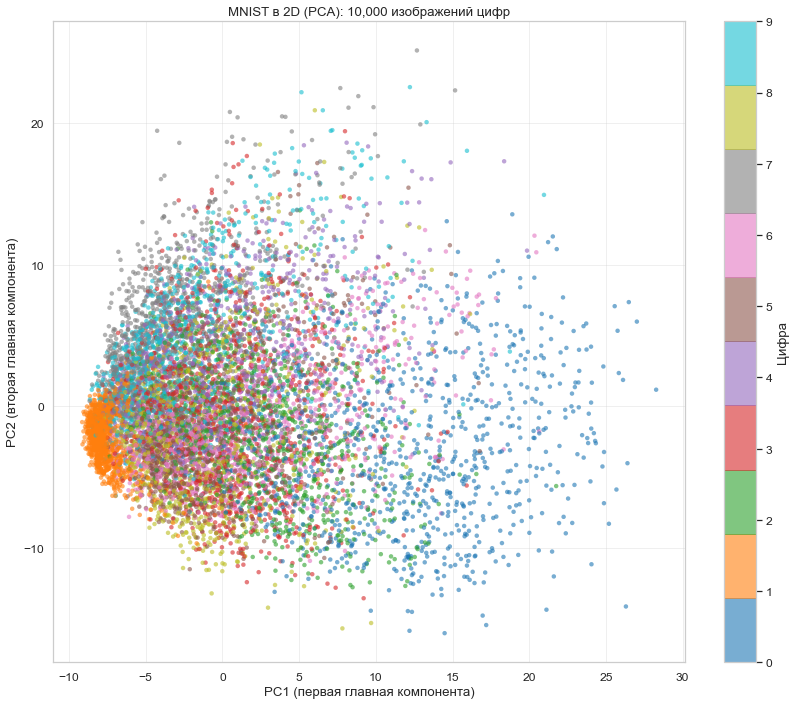

 Наблюдения:
  • Цифры образуют КЛАСТЕРЫ (каждый цвет = своё облако)
  • Некоторые цифры хорошо разделены (0, 1), другие перекрываются (4-9)
  • Из 784 измерений осталось 2 → можем визуализировать!
  • Но сохранено только ~20% дисперсии → много информации потеряно


In [10]:
# PCA → 2 компоненты для визуализации
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

print(f"PCA: 784 → 2 компоненты")
print(f"  Форма после PCA: {X_pca_2d.shape}")
print(f"  Explained variance:")
print(f"    PC1: {pca_2d.explained_variance_ratio_[0]:.2%}")
print(f"    PC2: {pca_2d.explained_variance_ratio_[1]:.2%}")
print(f"    Суммарно: {pca_2d.explained_variance_ratio_.sum():.2%}")

# КРИТИЧЕСКАЯ ВИЗУАЛИЗАЦИЯ: scatter plot 10,000 цифр в 2D
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                     c=y_subset, cmap='tab10', s=20, alpha=0.6, edgecolors='none')
plt.colorbar(scatter, ticks=range(10), label='Цифра')
plt.xlabel('PC1 (первая главная компонента)')
plt.ylabel('PC2 (вторая главная компонента)')
plt.title('MNIST в 2D (PCA): 10,000 изображений цифр')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(" Наблюдения:")
print("  • Цифры образуют КЛАСТЕРЫ (каждый цвет = своё облако)")
print("  • Некоторые цифры хорошо разделены (0, 1), другие перекрываются (4-9)")
print("  • Из 784 измерений осталось 2 → можем визуализировать!")
print("  • Но сохранено только ~20% дисперсии → много информации потеряно")

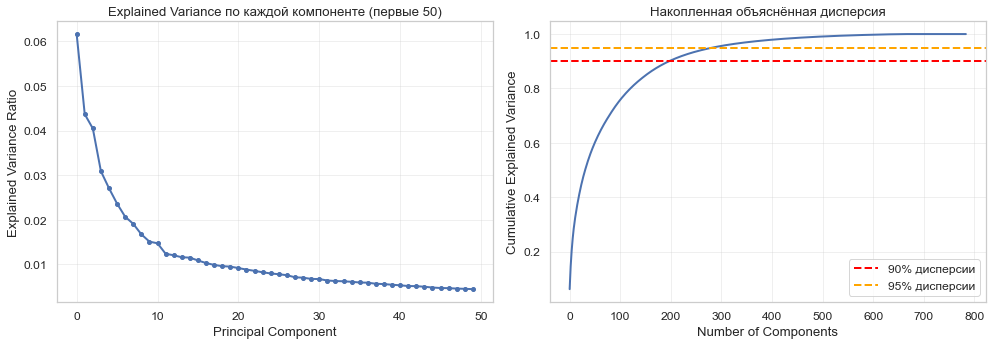


📊 Результаты:
  Для объяснения 90% дисперсии: 198 компонент (из 784)
  Для объяснения 95% дисперсии: 283 компонент

💡 Сжатие:
  784 → 198 = сжатие в 4.0 раз (90% информации)
  784 → 283 = сжатие в 2.8 раз (95% информации)


In [13]:
#Explained variance: сколько компонент нужно?
# PCA с ВСЕМИ компонентами (784)
pca_full = PCA(random_state=42)
pca_full.fit(X_scaled)

# Cumulative explained variance
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)
#вычисляет кумулятивную (накопленную) сумму объясненной дисперсии для всех 
#главных компонент после выполнения PCA. 
# pca_full.explained_variance_ratio_: Возвращает массив, где каждый элемент это доля дисперсии, 
#которую объясняет конкретная компонента (например, [0.4, 0.3, 0.2, 0.1]).
#np.cumsum(...): Функция NumPy считает сумму с накоплением. 
#Результат: Каждое число в cumsum_variance показывает, какой процент исходной информации (дисперсии) 
#удерживают первые n компонент вместе

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: explained variance по компонентам
axes[0].plot(pca_full.explained_variance_ratio_[:50], 'o-', linewidth=2, markersize=4)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Explained Variance по каждой компоненте (первые 50)')
axes[0].grid(True, alpha=0.3)

# График 2: cumulative explained variance
axes[1].plot(cumsum_variance, linewidth=2)
axes[1].axhline(0.9, color='red', linestyle='--', linewidth=2, label='90% дисперсии')
axes[1].axhline(0.95, color='orange', linestyle='--', linewidth=2, label='95% дисперсии')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Накопленная объяснённая дисперсия')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Сколько компонент нужно для 90% и 95%?
n_comp_90 = np.argmax(cumsum_variance >= 0.9) + 1
n_comp_95 = np.argmax(cumsum_variance >= 0.95) + 1

print(f"\n📊 Результаты:")
print(f"  Для объяснения 90% дисперсии: {n_comp_90} компонент (из 784)")
print(f"  Для объяснения 95% дисперсии: {n_comp_95} компонент")
print(f"\n💡 Сжатие:")
print(f"  784 → {n_comp_90} = сжатие в {784/n_comp_90:.1f} раз (90% информации)")
print(f"  784 → {n_comp_95} = сжатие в {784/n_comp_95:.1f} раз (95% информации)")

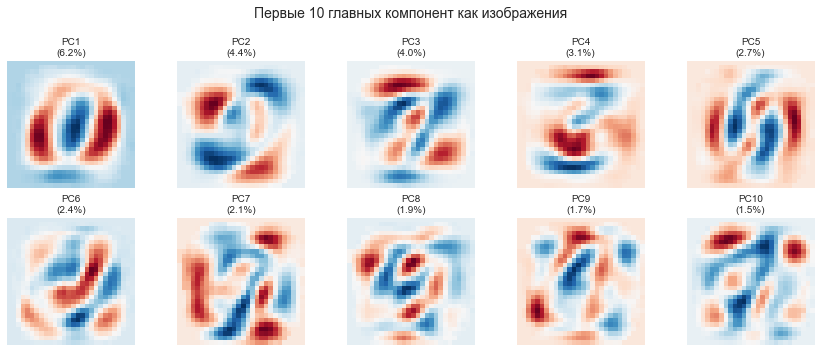

 Интерпретация главных компонент:
  • PC1 часто захватывает общую яркость/контрастность
  • PC2-10 захватывают паттерны (линии, изгибы) общие для всех цифр
  • Красные пиксели = положительный вклад, синие = отрицательный


In [15]:
# Первые 10 главных компонент можно визуализировать как изображения
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i, ax in enumerate(axes.flat):
    # Reshape component (784,) → (28, 28)
    component_image = pca_full.components_[i].reshape(28, 28)
    ax.imshow(component_image, cmap='RdBu_r')  # Красный=положит, синий=отрицат
    ax.set_title(f'PC{i+1}\n({pca_full.explained_variance_ratio_[i]:.1%})', fontsize=10)
    ax.axis('off')

plt.suptitle('Первые 10 главных компонент как изображения', fontsize=14)
plt.tight_layout()
plt.show()

print(" Интерпретация главных компонент:")
print("  • PC1 часто захватывает общую яркость/контрастность")
print("  • PC2-10 захватывают паттерны (линии, изгибы) общие для всех цифр")
print("  • Красные пиксели = положительный вклад, синие = отрицательный")

## Классификация на исходных и сжатых данных

In [16]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_subset, test_size=0.2, stratify=y_subset, random_state=42
)

print(f"Train: {X_train.shape[0]} samples")
print(f"Test:  {X_test.shape[0]} samples")

# Обучаем Logistic Regression на ПОЛНЫХ данных (784 признака)
print("\n=== BASELINE: Без PCA (784 признака) ===")
start_time = time.time()

lr_full = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_full.fit(X_train, y_train)
y_pred_full = lr_full.predict(X_test)

train_time_full = time.time() - start_time
acc_full = accuracy_score(y_test, y_pred_full)

print(f"  Время обучения: {train_time_full:.2f} сек")
print(f"  Test Accuracy:  {acc_full:.4f}")

Train: 8000 samples
Test:  2000 samples

=== BASELINE: Без PCA (784 признака) ===
  Время обучения: 33.49 сек
  Test Accuracy:  0.8780


In [17]:
# PCA: сжимаем до 150 компонент (90% дисперсии)
n_components = 150
pca = PCA(n_components=n_components, random_state=42)

# Применяем PCA к train и test
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)  # ТОЛЬКО transform (fit на train!)

print(f"\n=== С PCA ({n_components} компонент, {pca.explained_variance_ratio_.sum():.1%} дисперсии) ===")
start_time = time.time()

lr_pca = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_pca.fit(X_train_pca, y_train)
y_pred_pca = lr_pca.predict(X_test_pca)

train_time_pca = time.time() - start_time
acc_pca = accuracy_score(y_test, y_pred_pca)

print(f"  Время обучения: {train_time_pca:.2f} сек")
print(f"  Test Accuracy:  {acc_pca:.4f}")

print(f" Сравнение:")
print(f"  Ускорение: {train_time_full / train_time_pca:.1f}x")
print(f"  Падение accuracy: {(acc_full - acc_pca)*100:.1f} п.п.")
print(f"  Сжатие: 784 → {n_components} ({784/n_components:.1f}x)")


=== С PCA (150 компонент, 85.4% дисперсии) ===
  Время обучения: 9.70 сек
  Test Accuracy:  0.9130
 Сравнение:
  Ускорение: 3.5x
  Падение accuracy: -3.5 п.п.
  Сжатие: 784 → 150 (5.2x)


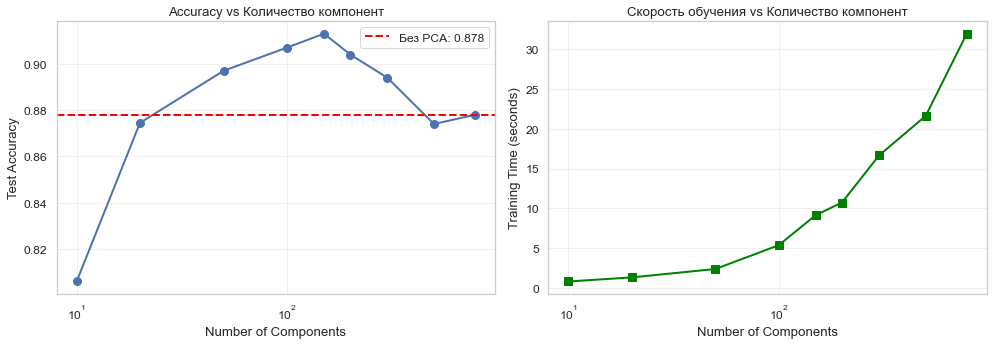

 Выводы:
  • 50-100 компонент: accuracy ≈ 85-90% (падение 5-10% от max)
  • 150-200 компонент: accuracy ≈ 92-95% (близко к max)
  • 300+ компонент: accuracy ~97% (как без PCA), но обучение медленнее
  • Оптимум: 150 компонент — баланс accuracy и скорости


In [19]:
# Как количество компонент влияет на accuracy?
n_comp_list = [10, 20, 50, 100, 150, 200, 300, 500, 784]
accuracies = []
train_times = []

for n in n_comp_list:
    if n < X_train.shape[1]:  # n <= 784
        pca_temp = PCA(n_components=n, random_state=42)
        X_train_temp = pca_temp.fit_transform(X_train)
        X_test_temp = pca_temp.transform(X_test)
    else:
        # n=784 → без PCA
        X_train_temp = X_train
        X_test_temp = X_test
    
    start = time.time()
    lr_temp = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
    lr_temp.fit(X_train_temp, y_train)
    train_time = time.time() - start
    
    acc = accuracy_score(y_test, lr_temp.predict(X_test_temp))
    
    accuracies.append(acc)
    train_times.append(train_time)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Accuracy vs компоненты
axes[0].plot(n_comp_list, accuracies, 'o-', linewidth=2, markersize=8)
axes[0].axhline(acc_full, color='red', linestyle='--', linewidth=2, 
                label=f'Без PCA: {acc_full:.3f}')
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Accuracy vs Количество компонент')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')

# График 2: Время обучения
axes[1].plot(n_comp_list, train_times, 's-', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Training Time (seconds)')
axes[1].set_title('Скорость обучения vs Количество компонент')
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')

plt.tight_layout()
plt.show()

print(" Выводы:")
print("  • 50-100 компонент: accuracy ≈ 85-90% (падение 5-10% от max)")
print("  • 150-200 компонент: accuracy ≈ 92-95% (близко к max)")
print("  • 300+ компонент: accuracy ~97% (как без PCA), но обучение медленнее")
print("  • Оптимум: 150 компонент — баланс accuracy и скорости")

## Реконструкция изображений  inverse_transform

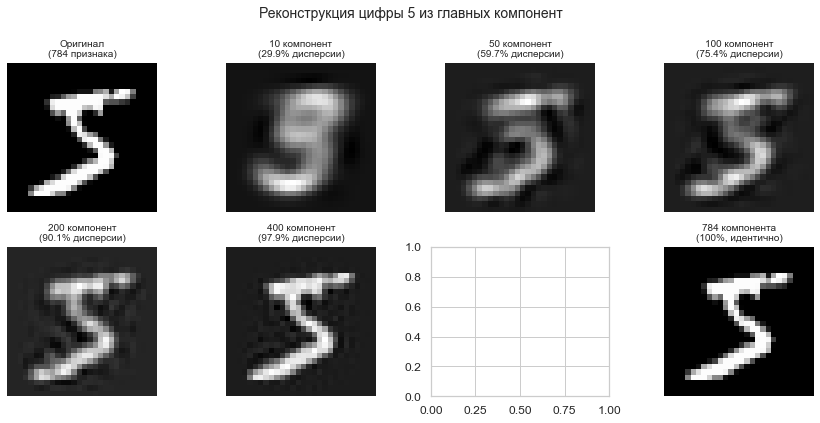

 Наблюдения:
  • 10 компонент: размытая, едва узнаваемая
  • 50 компонент: форма цифры видна, детали смазаны
  • 100 компонент: хорошее качество
  • 200+ компонент: почти неотличимо от оригинала

💾 Сжатие:
  Оригинал: 784 числа (float32) ≈ 3.1 KB
  100 компонент: 100 чисел ≈ 0.4 KB → сжатие в 7.8 раз


In [20]:
# Возьмём одно изображение и реконструируем его с разным количеством компонент
sample_idx = 0
sample_image = X_scaled[sample_idx].reshape(1, -1)  # (1, 784)
sample_label = y_subset[sample_idx]

# Список количеств компонент для сравнения
n_comp_recon = [10, 50, 100, 200, 400, 784]
reconstructions = []

for n in n_comp_recon:
    pca_temp = PCA(n_components=min(n, X_scaled.shape[1]), random_state=42)
    pca_temp.fit(X_scaled)
    
    # Сжимаем и восстанавливаем
    compressed = pca_temp.transform(sample_image)
    reconstructed = pca_temp.inverse_transform(compressed)
    
    # Обратно к пикселям (denormalize)
    reconstructed_img = scaler.inverse_transform(reconstructed).reshape(28, 28)
    reconstructions.append(reconstructed_img)

# Визуализация
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Исходное изображение
original_img = scaler.inverse_transform(sample_image).reshape(28, 28)
axes[0, 0].imshow(original_img, cmap='gray')
axes[0, 0].set_title('Оригинал\n(784 признака)', fontsize=10)
axes[0, 0].axis('off')

# Реконструкции
for i, (n, recon) in enumerate(zip(n_comp_recon[:-1], reconstructions[:-1]), 1):
    row, col = divmod(i, 4)
    pca_temp = PCA(n_components=n, random_state=42)
    pca_temp.fit(X_scaled)
    var_explained = pca_temp.explained_variance_ratio_.sum()
    
    axes[row, col].imshow(recon, cmap='gray')
    axes[row, col].set_title(f'{n} компонент\n({var_explained:.1%} дисперсии)', fontsize=10)
    axes[row, col].axis('off')

# Последняя ячейка — полная реконструкция (784 компонента)
axes[1, 3].imshow(reconstructions[-1], cmap='gray')
axes[1, 3].set_title('784 компонента\n(100%, идентично)', fontsize=10)
axes[1, 3].axis('off')

plt.suptitle(f'Реконструкция цифры {sample_label} из главных компонент', fontsize=14)
plt.tight_layout()
plt.show()

print(" Наблюдения:")
print("  • 10 компонент: размытая, едва узнаваемая")
print("  • 50 компонент: форма цифры видна, детали смазаны")
print("  • 100 компонент: хорошее качество")
print("  • 200+ компонент: почти неотличимо от оригинала")
print("\n💾 Сжатие:")
print(f"  Оригинал: 784 числа (float32) ≈ 3.1 KB")
print(f"  100 компонент: 100 чисел ≈ 0.4 KB → сжатие в 7.8 раз")

In [21]:
# Практическое применение: сжатие всего датасета для хранения
n_comp_storage = 100

pca_storage = PCA(n_components=n_comp_storage, random_state=42)
X_compressed = pca_storage.fit_transform(X_scaled)

# Размеры
size_original = X_scaled.nbytes / 1024 / 1024  # MB
size_compressed = X_compressed.nbytes / 1024 / 1024
size_pca_model = (pca_storage.components_.nbytes + pca_storage.mean_.nbytes) / 1024 / 1024

print(f"Размеры данных:")
print(f"  Оригинал ({X_scaled.shape}): {size_original:.2f} MB")
print(f"  Сжатое ({X_compressed.shape}): {size_compressed:.2f} MB")
print(f"  PCA модель (components + mean): {size_pca_model:.2f} MB")
print(f"  Итого сжатое: {size_compressed + size_pca_model:.2f} MB")
print(f" Сжатие: {size_original / (size_compressed + size_pca_model):.1f}x")
print(f"   Сохранено {pca_storage.explained_variance_ratio_.sum():.1%} дисперсии")

print(" Применения PCA-сжатия:")
print("  • Хранение больших датасетов (экономия места на диске)")
print("  • Ускорение обучения (меньше признаков → быстрее вычисления)")
print("  • Передача по сети (меньше данных для отправки)")
print("  • Визуализация (проекция на 2-3D)")

Размеры данных:
  Оригинал ((10000, 784)): 59.81 MB
  Сжатое ((10000, 100)): 7.63 MB
  PCA модель (components + mean): 0.60 MB
  Итого сжатое: 8.23 MB
 Сжатие: 7.3x
   Сохранено 75.4% дисперсии
 Применения PCA-сжатия:
  • Хранение больших датасетов (экономия места на диске)
  • Ускорение обучения (меньше признаков → быстрее вычисления)
  • Передача по сети (меньше данных для отправки)
  • Визуализация (проекция на 2-3D)
